# Metrics Aggregation by Experiment
This notebook aggregates metrics from all_metrics.csv by experiment name,
showing mean and standard deviation for coverage, mutation score, and tokens used.

/Users/luigi/Documents/MSc-PoliTO/II_anno/LLM4SE/LLM-Agents-for-Collaborative-Test-Case/src/utils/plot_metrics.py:94: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


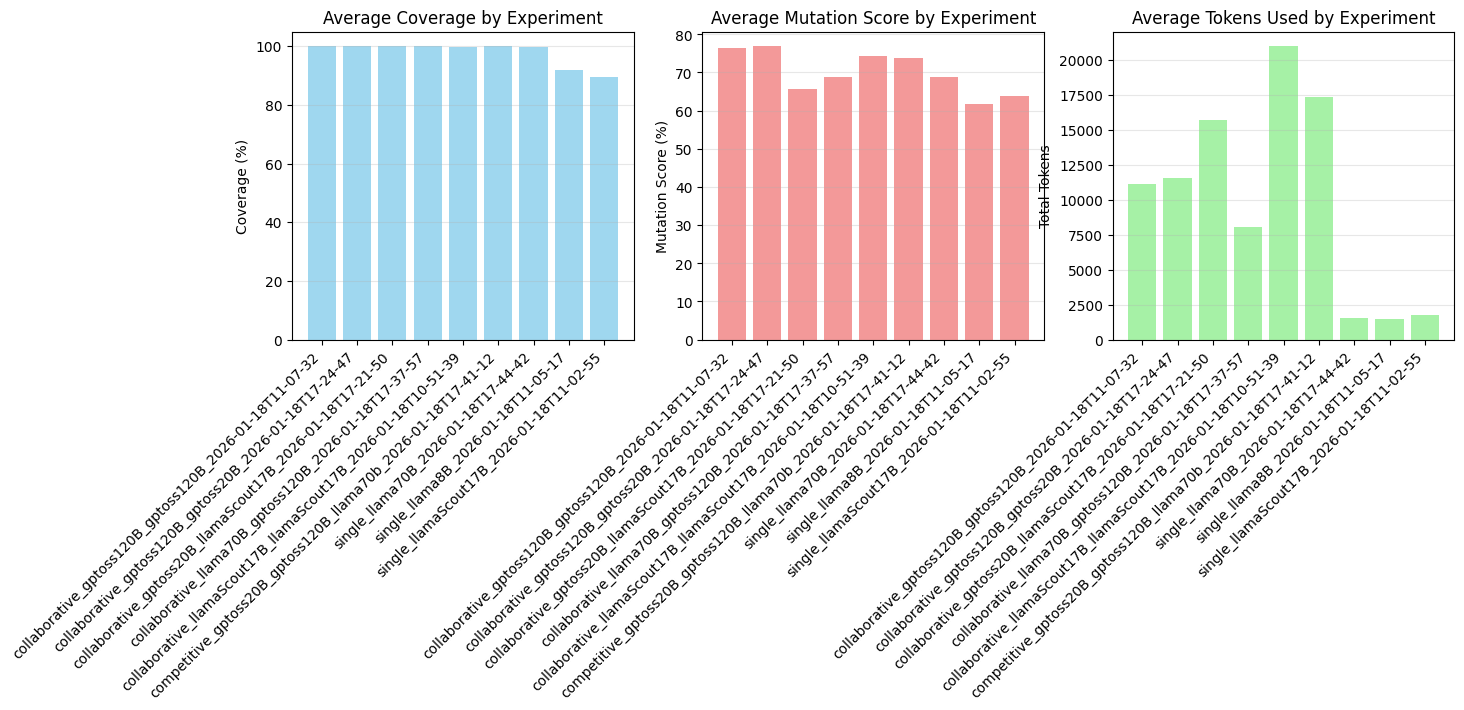

In [1]:
import sys

sys.path.append("src")

from utils.plot_metrics import plot_metrics

# Execute plot_metrics to show individual run metrics
plot_metrics()

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Load the metrics data
df = pd.read_csv("all_metrics.csv")
print(f"Loaded {len(df)} rows from all_metrics.csv")
print(f"Columns: {df.columns.tolist()}")

Loaded 45 rows from all_metrics.csv
Columns: ['run_id', 'experiment_name', 'timestamp', 'temperature', 'file', 'status', 'coverage_percent', 'n_passed_tests', 'n_failed_tests', 'iterations', 'total_tokens', 'mutation_score_percent', 'mutation_killed', 'mutation_survived']


In [4]:
# Aggregate metrics by experiment_name
# Focus on: coverage_percent, mutation_score_percent, total_tokens

aggregated = (
    df.groupby("experiment_name")
    .agg(
        {
            "coverage_percent": ["mean", "std"],
            "mutation_score_percent": ["mean", "std"],
            "total_tokens": ["mean", "std"],
        }
    )
    .round(2)
)

# Flatten column names
aggregated.columns = ["_".join(col).strip() for col in aggregated.columns.values]
aggregated = aggregated.reset_index()

In [5]:
# Create a summary table for reference
result_df = pd.DataFrame()
result_df["Experiment"] = aggregated["experiment_name"]
result_df["Coverage Mean"] = aggregated["coverage_percent_mean"]
result_df["Coverage Std"] = aggregated["coverage_percent_std"]
result_df["Mutation Mean"] = aggregated["mutation_score_percent_mean"]
result_df["Mutation Std"] = aggregated["mutation_score_percent_std"]
result_df["Tokens Mean"] = aggregated["total_tokens_mean"].astype(int)
result_df["Tokens Std"] = aggregated["total_tokens_std"].round(0).astype(int)

result_df

,Experiment,Coverage Mean,Coverage Std,Mutation Mean,Mutation Std,Tokens Mean,Tokens Std
0,collaborative_gptoss120B_gptoss120B,100.0,0.00,76.53,17.67,11102,8505
1,collaborative_gptoss120B_gptoss20B,100.0,0.00,NaN,NaN,11550,5702
2,collaborative_gptoss20B_llamaScout17B,100.0,0.00,NaN,NaN,15739,8410
3,collaborative_llama70B_gptoss120B,100.0,0.00,NaN,NaN,8059,5933
4,collaborative_llamaScout17B_llamaScout17B,99.6,0.89,74.29,12.85,20991,22887
5,competitive_gptoss20B_gptoss120B_llama70b,100.0,0.00,NaN,NaN,17385,4336
6,single_llama70B,99.6,0.89,NaN,NaN,1549,537
7,single_llama8B,91.8,6.87,61.72,17.23,1483,417
8,single_llamaScout17B,89.4,21.54,63.76,31.07,1724,613


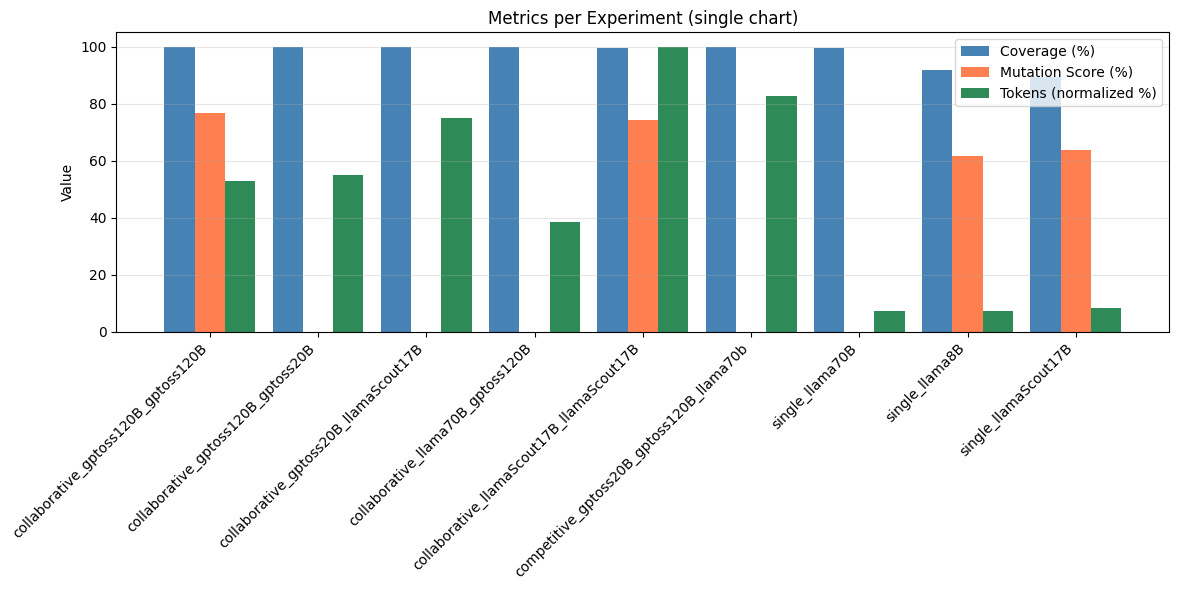

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Single grouped chart for all metrics
fig, ax = plt.subplots(figsize=(12, 6))

experiments = aggregated["experiment_name"]
x = np.arange(len(experiments))
width = 0.28

# Normalize tokens to percentage scale to fit with coverage/mutation
tokens_norm = (
    aggregated["total_tokens_mean"] / aggregated["total_tokens_mean"].max()
) * 100

bars1 = ax.bar(
    x - width,
    aggregated["coverage_percent_mean"],
    width,
    label="Coverage (%)",
    color="steelblue",
)
bars2 = ax.bar(
    x,
    aggregated["mutation_score_percent_mean"],
    width,
    label="Mutation Score (%)",
    color="coral",
)
bars3 = ax.bar(
    x + width, tokens_norm, width, label="Tokens (normalized %)", color="seagreen"
)

ax.set_title("Metrics per Experiment (single chart)")
ax.set_ylabel("Value")
ax.set_xticks(x)
ax.set_xticklabels(experiments, rotation=45, ha="right")
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()

plt.show()